# 필요 라이브러리 import

In [451]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import copy
import matplotlib.pyplot as plt

# 입력 이미지 전처리 및

In [452]:
# contents 이미지 경로
content_image_path = "A beach with a natural rock arch.png"
# style 이미지 경로
style_image_path = "04.jpg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

content_img = Image.open(content_image_path).convert('RGB')
style_img = Image.open(style_image_path).convert('RGB')

size = content_img.size

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(), # 이미지를 0~1의 범위로 만드는데
    transforms.Lambda(lambda x: x.mul(255)) # 이미지를 네트워크에 맞게 재조정
])

# ImageNet의 정규화값
mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

content_img = transform(content_img).unsqueeze(0).to(device, torch.float)
style_img = transform(style_img).unsqueeze(0).to(device, torch.float)
input_img = content_img.clone()

In [453]:
# content, style이미지가 같은 크기인지 확인
print(content_img.size())
print(style_img.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


# Pretrained모델(VGG19) 가져오기

In [454]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Style Transfer 코드 구현

In [455]:
def gram_matrix(tensor): # 스타일 손실 계산에 사용됨
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    gram = torch.mm(features, features.t()) # feature map 벡터를 내적하여 채널 간 상관관계를 추출
    return gram

In [456]:
class ContentLoss(nn.Module): # 생성, 콘텐츠 이미지의 feature map 차이 계산
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.weight = weight
        self.loss = 0

    def forward(self, input): # MSE Loss를 통해 계산함
        self.loss = self.weight * nn.functional.mse_loss(input, self.target)
        return input

In [457]:
class StyleLoss(nn.Module): # 생성, 스타일 이미지의 스타일 정보 차이를 측정
    def __init__(self, target_feature, weight):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() # Gram matrix의 차이를 계산
        self.weight = weight
        self.loss = 0

    def forward(self, input): # MSE Loss를 통해 계산함
        G = gram_matrix(input)
        self.loss = self.weight * nn.functional.mse_loss(G, self.target)
        return input

In [458]:
class Normalization(nn.Module): # 입력 이미지의 각 채널을 정규화하여 픽셀값들이 표준정규분포에 가까워지도록 변환
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

In [459]:
def get_style_loss(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layer='conv_4', 
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # 컨볼루션 레이어 카운터
    for layer in cnn.children(): # 레이어를 순회하며 이름을 붙여줌
        if isinstance(layer, nn.Conv2d): # conv layer
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU): # ReLU layer
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d): # MaxPool layer
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d): # BatchNorm layer
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)

        # 콘텐츠 손실 추가
        if name == content_layer:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, weight=1)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        
        # 스타일 손실 추가
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, weight=1e6 / len(style_layers))
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    # 불필요한 연산을 줄이기 위해 마지막 손실모듈 이후 레이어는 없앰
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i+1)]
    return model, style_losses, content_losses

In [460]:
def style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_loss(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= num_steps: # epoch수가 num_step만큼이다

        def closure(): # LBFGS내에서 손실함수를 재평가함
            input_img.data.clamp_(0, 255)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            #가중치를 곱하여 loss도출
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                b, c, h, w = input_img.size()
                print("Step {}: 스타일 손실: {:4f}, 콘텐츠 손실: {:4f}".format(
                    run[0], style_score.item(), content_score.item()))
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 255)
    return input_img

In [461]:
output = style_transfer(cnn, mean, std,
                            content_img, style_img, input_img,
                            num_steps=300, style_weight=1e6, content_weight=1)

Step 50: 스타일 손실: 5111011619110912.000000, 콘텐츠 손실: 29.811934
Step 100: 스타일 손실: 952125194502144.000000, 콘텐츠 손실: 33.560616
Step 150: 스타일 손실: 166074557399040.000000, 콘텐츠 손실: 34.512375
Step 200: 스타일 손실: 57776571154432.000000, 콘텐츠 손실: 34.606220
Step 250: 스타일 손실: 19925395570688.000000, 콘텐츠 손실: 34.802063
Step 300: 스타일 손실: 8921612812288.000000, 콘텐츠 손실: 35.130638


# 결과 시각화 및 저장

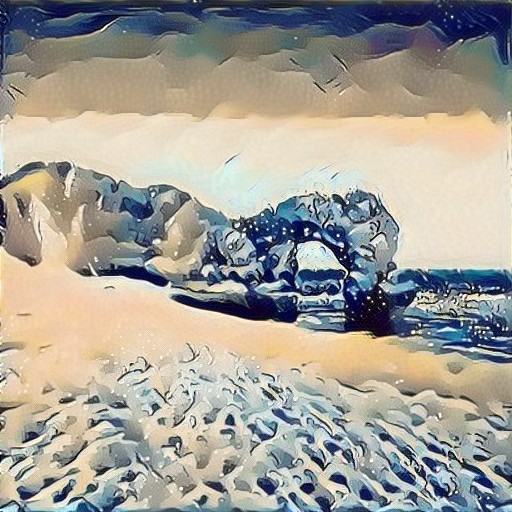

In [462]:
output_image = output.to("cpu").clone().detach()
output_image = output_image.squeeze(0)
output_image = output_image.clamp(0, 255).numpy()
output_image = output_image.transpose(1, 2, 0).astype("uint8")
output_image = Image.fromarray(output_image)
output_image.show()
output_image.save("output.png")

# 스타일 전이 결과 시각화

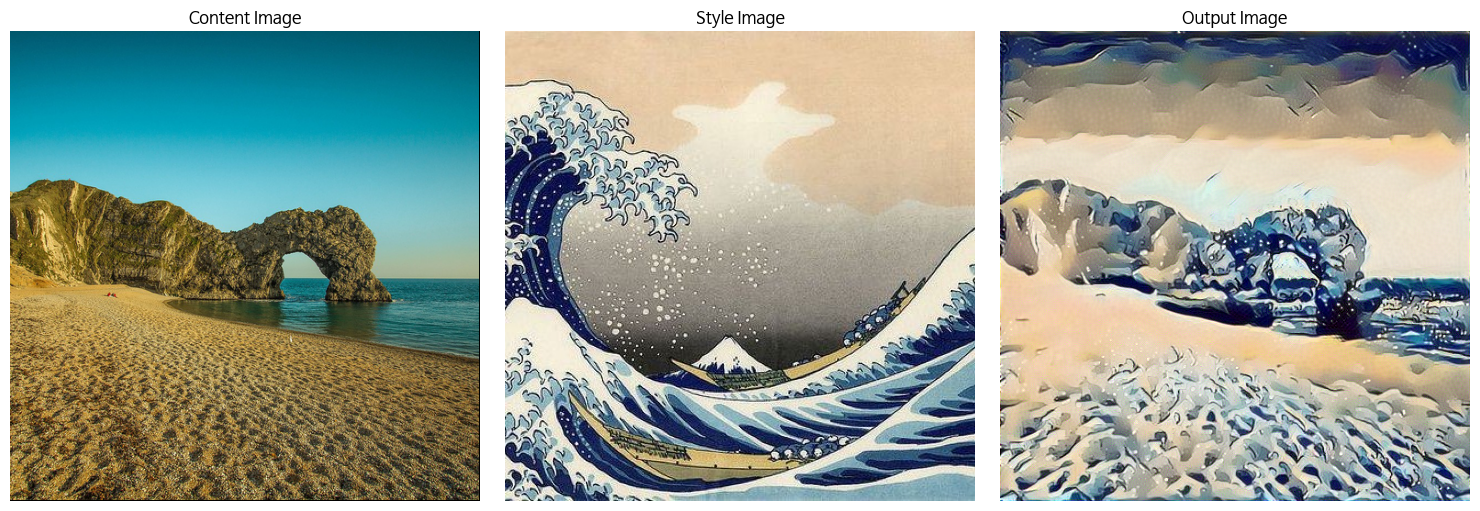

In [463]:
content_img = plt.imread(content_image_path)
style_img = plt.imread(style_image_path)
output_img = plt.imread("output.png")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(content_img)
axes[0].set_title("Content Image")
axes[0].axis("off")

axes[1].imshow(style_img)
axes[1].set_title("Style Image")
axes[1].axis("off")

axes[2].imshow(output_img)
axes[2].set_title("Output Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# 보고서

## 1. StyleBench 데이터셋

Style Transfer의 성능을 평가하기 위한 벤치마킹 데이터셋

- 데이터 개수

Content : 40장

Style : 490장(73개의 스타일로 각 스타일 당 5~7개의 이미지가 있다.)

    <스타일 예시>
    - 3D Model
    - Abstract
    - Baroque
    - Pixel Art
    - 등등

## 2. 실험 특징

- Pretrained Model

  모델 학습을 진행하진 않고, 학습이 종료된 VGG19모델을 가져와 특정 layer의 feature map의 비교를 통해 content, style loss 도출

  모델의 구조를 이름으로 변경하여 필요한 레이어 도달 시 Loss계산, 불필요한 layer는 제거합니다.

- instance norm

  스타일 정보를 gram matrix를 통해 채널 간의 상관관계를 계산하는 식으로 표현하는데 layer norm 등 다른 방식을 통해 정규화를 할 경우 스타일 정보가 왜곡되거나 필요한 세부 정보를 잃을 수도 있기 때문에 instance norm을 사용한다.

  

## 4. 실험 결과

### 4-1. 결과 1

content:Clean house building

style:popart02

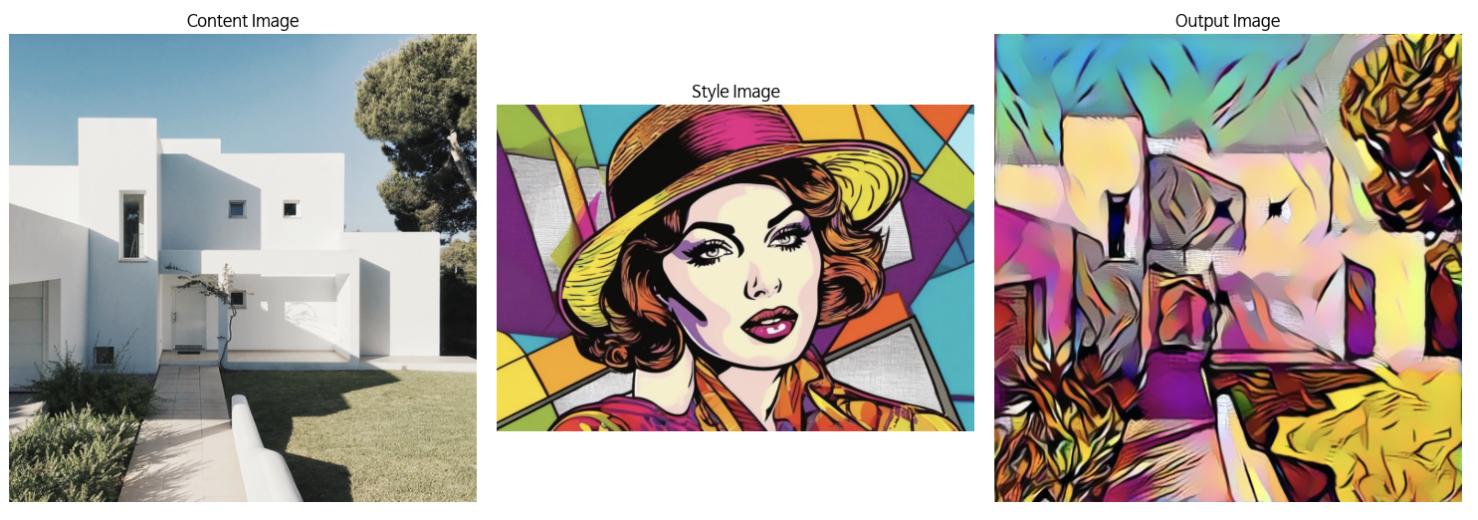

## 4-2. 결과 2
content: A lion's head

style : LineArt00

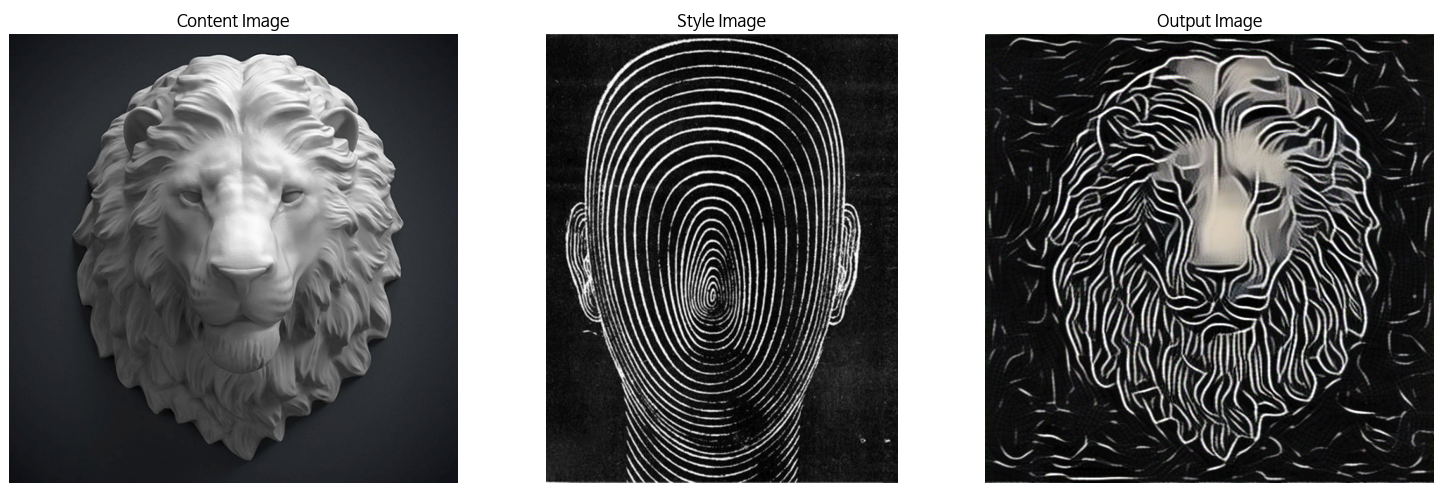

## 4-3. 결과 3
content: A beach with a natural rock arch 

style: Japonism04

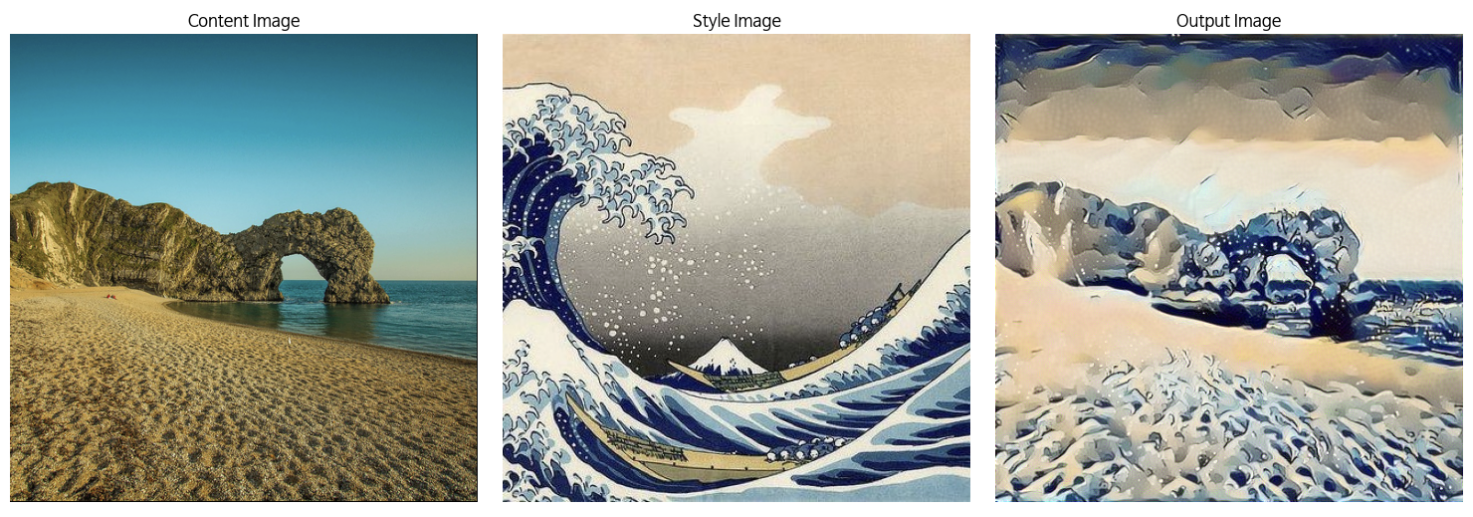

## 5. 분석 및 고찰

- 학습에 사용되는 첫 input값이 content이미지이기 때문에 학습이 진행됨에 따라 content loss에 비해 style loss가 급격하게 줄어드는 모습을 보인다.

- 또한 style loss는 Gram matrix를 통한 loss를 도출하였기 때문에 content loss에 비해 절대값이 매우 크게 나타난다. 이를 보정하기 위해 C, W, H로 나누어 정규하는 방법도 생각해 보아야 할 것 같다. 이 때, loss 자체를 정규화하면 학습이 느리게 진행될 수 있으므로, 출력되는 값만 정규화해야 하는 것이 좋아보인다.

- 이 실험에선 첫 input값이 content이미지이지만, 랜덤 노이즈 이미지를 통해 학습하는 방법이 있는데 content이미지의 경우 컨텐츠 이미지를 보조하며 빠르고 안정적으로 스타일을 반영할 수 있을 것이다. 반면 랜덤 노이즈 이미지의 경우 더 많은 스타일을 반영하여 다양한 결과가 나오지만 수렴이 느릴 것이라고 생각한다.